### Modules

In [5]:
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import numpy as np

### Load data

In [6]:
boston = load_boston()
y = boston.target
X = pd.DataFrame(boston.data, columns = boston.feature_names)
np.random.seed(seed = 42)
X['random'] = np.random.random(size = len(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.8, random_state = 42)

### Model

In [7]:
from sklearn.ensemble import RandomForestRegressor
#100 trees,
#-1:use all processors
#oob_score = True: use out-of-bag to estimate r2
#bootstrap = True: use bootstrap samples, sampling with replacement
rf = RandomForestRegressor(n_estimators = 100,
                          n_jobs = -1,
                          oob_score = True,
                          bootstrap = True,
                          random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)

In [8]:
print('R2 Training Score:{:.2f} \nOOB Score:{:.2f} \nR2 Testing Score:{:.2f}'.format(rf.score(X_train, y_train),
                                                                                     rf.oob_score_,
                                                                                     rf.score(X_test, y_test)))

R2 Training Score:0.93 
OOB Score:0.58 
R2 Testing Score:0.76


### Plot Features importance

#### Default

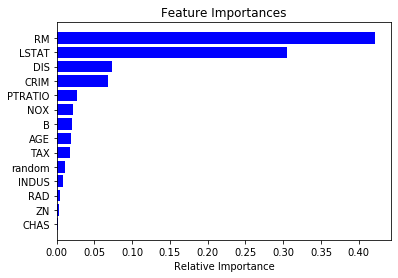

In [22]:
features = X.columns
importances = rf.feature_importances_
#sort value in ascending order and return indices
indices = np.argsort(importances)

import matplotlib.pyplot as plt
%matplotlib inline

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Top 3 features are average number of rooms (RM), % lower status of population (LSTAT) and weighted distance to five Boston employment centers

Surprising news is random (random) is more important than other useful features

Pro: fast calculation and easy to retrieve
Con: inflate importance of continuous features or high-cardinality categorical values (with many levels)

#### permutation feature importance

1. Train baseline model and record score by passing testing set (or oob = True)
2. Reshuffle values from one feature, pass dataset to obtain prediction and metric, feature importance is the difference between benchmark score and new score
3. Repeat for all features

In [24]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

D:\Users\figohjs\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [26]:
def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

permutation_rf = permutation_importances(rf, X_train, y_train, r2)

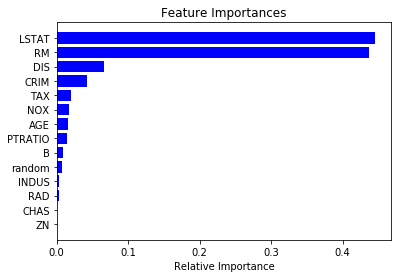

In [31]:
features = permutation_rf.index
importances = permutation_rf['Importance'].values
#sort value in ascending order and return indices
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

result is still the same as prevous one

In [ ]:
#using different library
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, cv = None, n_iter = 50).fit(X_train, y_train)
permutation_elif = imp_df(X_train.columns, perm.feature_importances_)

#### Drop Column feature importance

investigate importance of a feature by comparing a model with all features versus a model with this feature dropped
(high computation cost)

In [37]:
from sklearn.base import clone

def dropCol_featureImportance(model, X_train, y_train, random_state = 42):
    #clone the model to have same specification
    model_clone = clone(model)
    model_clone.random_state = random_state
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    #record importances
    importances = []
    
    #iteration
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        #after drop that col, score
        dropCol_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - dropCol_score)
        
#     importances_df = imp_df(X_train.columns, importances)
#     return importances_df
    importances_df = pd.DataFrame({"Features":X_train.columns, "Importance":importances})
    return importances_df

In [38]:
resultDf = dropCol_featureImportance(rf, X_train, y_train)

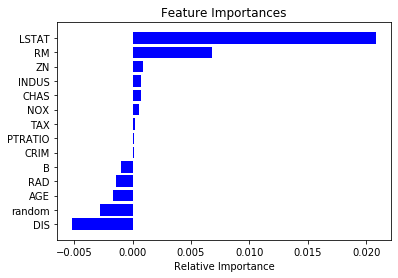

In [40]:
features = resultDf['Features']
importances = resultDf['Importance'].values
#sort value in ascending order and return indices
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [49]:
#only select features with positive relative importance
colList = resultDf.query("Importance > 0")['Features'].values

X2 = X[colList]
np.random.seed(seed = 42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size = 0.8, random_state = 42)

In [50]:
rf2 = RandomForestRegressor(n_estimators = 100,
                          n_jobs = -1,
                          oob_score = True,
                          bootstrap = True,
                          random_state = 42)
rf2.fit(X2_train, y2_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)

In [41]:
print("Before\n")
print('R2 Training Score:{:.2f} \nOOB Score:{:.2f} \nR2 Testing Score:{:.2f}'.format(rf.score(X_train, y_train),
                                                                                     rf.oob_score_,
                                                                                     rf.score(X_test, y_test)))

Before

R2 Training Score:0.93 
OOB Score:0.58 
R2 Testing Score:0.76


In [52]:
print("After - select features with positive relative importance\n")
print('R2 Training Score:{:.2f} \nOOB Score:{:.2f} \nR2 Testing Score:{:.2f}'.format(rf2.score(X2_train, y2_train),
                                                                                     rf2.oob_score_,
                                                                                     rf2.score(X2_test, y2_test)))

After - select features with positive relative importance

R2 Training Score:0.93 
OOB Score:0.60 
R2 Testing Score:0.76
